In [1]:
#!pip install langdetect
#!pip install scattertext
#!pip install spacy

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [26]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os 
import re
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import spacy
import spacy
import scattertext

In [8]:
df = pd.read_excel('./data/fake_job_postings.xlsx')

Basic Cleaning 
- Replace null to string "missing" -- instead of dropping missings, use as a valid observation. Could be that fake posts often have missing fields
- Separate country, state, city from location
- Drop non-english text entries
- Clean text columns: remove non-ascii, punctuation, extra spaces and white space
- Redefine education bins
- Drop salary range: very often missing, unsure what units are used in foreign countries, inconsistent time frame (hourly, monthly, yearly)

In [9]:
for c in df.columns:
    df[c] = np.where(df[c].isnull(), 'missing', df[c])

In [10]:
df['country'] = df.location.str.split(',').str[0]
df['state'] = df.location.str.split(', ').str[1]
df['city'] = df.location.str.split(', ').str[2]

In [11]:
df['language'] = df['description'].apply(lambda x: detect(x))
df = df[df.language == 'en']

In [12]:
text_columns = ['country', 'state', 'city', 'title', 'department', 'company_profile', 'description', 'requirements',
               'benefits', 'required_experience', 'employment_type', 'required_education', 'industry', 'function']
for c in text_columns:
    df[c] = df[c].str.lower() # downcase 
    df[c] = np.where(df[c] == '', 'missing', df[c]) 
    df[c] = df[c].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in str(x)])) # remove non-ascii
    df[c] = df[c].apply(lambda x: re.sub(r'[^\w\s]',' ', x)) # remove punctuation
    df[c] = df[c].apply(lambda x: re.sub(' +', ' ', x)) # remove double and triple spaces
    df[c] = df[c].apply(lambda x: str(x).strip()) # remove white space trailing/leading

In [13]:
df.city = np.where(df.city == 'nyc', 'new york city', df.city)
df.city = np.where(df.city == 'ny', 'new york city', df.city)
df.city = np.where(df.city == 'new york', 'new york city', df.city)

In [14]:
# redefine education bins
df['education_bin'] = np.where(df.required_education.isin(['some high school coursework']),
                               'less than high school', df.required_education)
df.education_bin = np.where(df.required_education.isin(['high school or equivalent']), 'high school', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['vocational hs diploma', 'vocational degree',
                                                       'vocational']), 'vocational', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['some college coursework completed']), 'some college', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['bachelor s degree']), "bachelor's degree", df.education_bin)
df.education_bin = np.where(df.required_education.isin(['master s degree']), "master's degree", df.education_bin)
df.education_bin = np.where(df.required_education.isin(['unspecified']), "missing", df.education_bin)

In [15]:
del df['salary_range']

## EDA

In [16]:
df.fraudulent = pd.to_numeric(df.fraudulent)

In [177]:
def bar_plt(col, titlecol, boolean = False):
    
    # count number of fraudulent postings and total postings -> calculate fraction of postings that are fraud
    fraudcnt = df.groupby(col).fraudulent.sum().to_frame()
    totcnt = df.groupby(col).job_id.count().to_frame()
    frac = pd.merge(fraudcnt, totcnt, left_index = True, right_index = True)
    frac['frac'] = frac.fraudulent / frac.job_id 
    
    # exclude if fewer than 10 total postings (else fraction may be close to 100%)
    frac = frac[frac.job_id > 10]
    
    # sort and take top 10 
    frac['index_col'] = frac.index
    frac = frac.reset_index(drop = True)
    if boolean == False:
        frac = frac.sort_values('frac').tail(10)

    # plot
    cnt = len(frac)
    sns.barplot(x='index_col', y="frac", data=frac, order=frac['index_col'])
    if boolean == False:
        plt.xticks(rotation=90)
    else:
        plt.xticks([0, 1], ['No', 'Yes'])
        
    if cnt == 10:
        plt.title('Top 10 ' + titlecol + ' by Percent Fraudulent Postings')
    else:
        plt.title(titlecol + ' by Percent Fraudulent Postings')
        
    plt.ylabel('Fraction of Fraudulent Postings')
    plt.xlabel('')

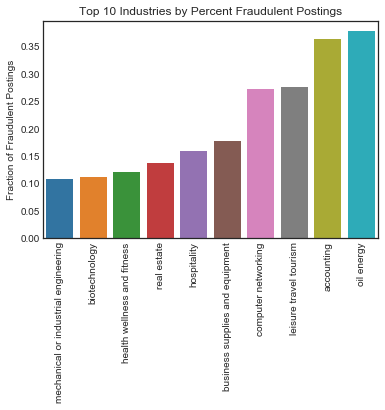

In [133]:
bar_plt('industry', 'Industries')

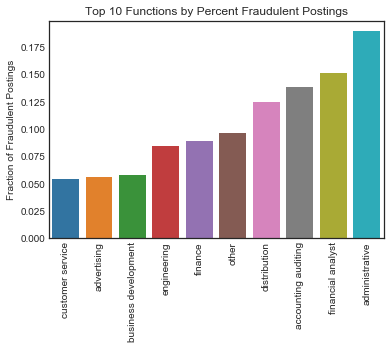

In [134]:
bar_plt('function', 'Functions')

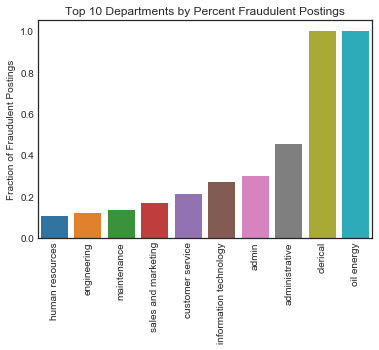

In [136]:
bar_plt('department', 'Departments')
# clerical and oil energy appear to be the same handful of job postings posted many times with different locations or titles

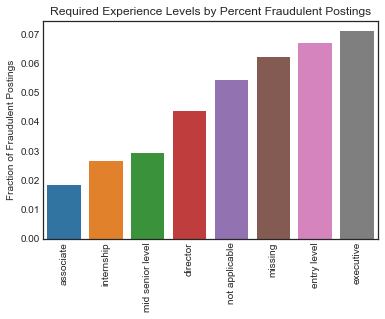

In [137]:
bar_plt('required_experience', 'Required Experience Levels')

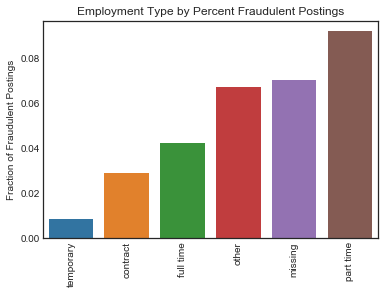

In [138]:
bar_plt('employment_type', 'Employment Type')

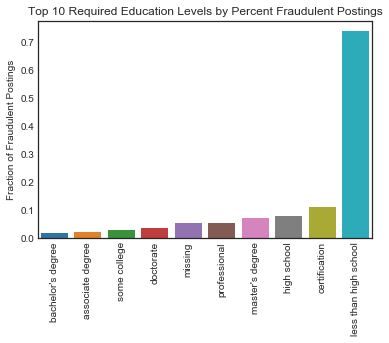

In [151]:
bar_plt('education_bin', 'Required Education Levels')

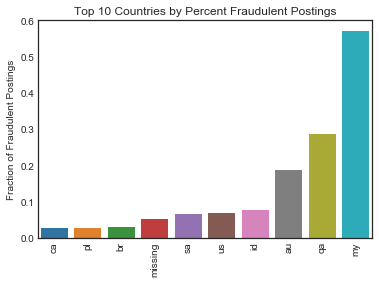

In [154]:
bar_plt('country', 'Countries')

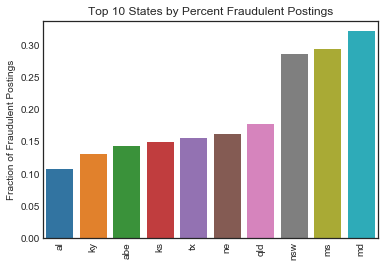

In [155]:
bar_plt('state', 'States')

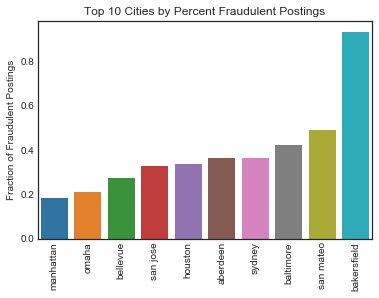

In [158]:
bar_plt('city', 'Cities')

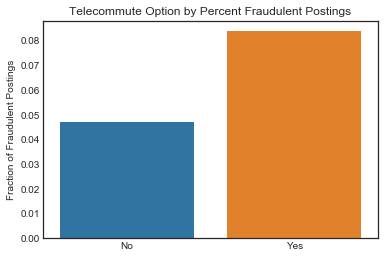

In [179]:
bar_plt('telecommuting', 'Telecommute Option', boolean = True)

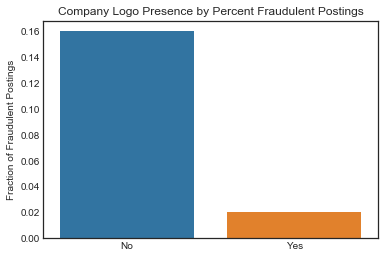

In [180]:
bar_plt('has_company_logo', 'Company Logo Presence', boolean = True)

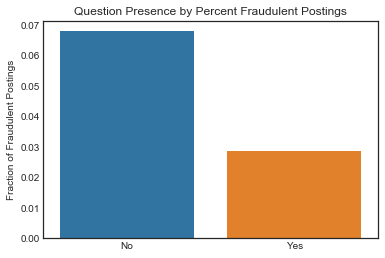

In [181]:
bar_plt('has_questions', 'Question Presence', boolean = True)

In [201]:
!pip install wordcloud

  Created wheel for wordcloud: filename=wordcloud-1.7.0-cp36-cp36m-win32.whl size=150956 sha256=c67774dcfd966e8be37a6be8517a41612b52104c7709622a7582ad2c01b692a6
  Stored in directory: C:\Users\Gimli\AppData\Local\pip\Cache\wheels\91\ab\7c\24d88188b6842f83e5aa3087b2b4186525651bf0a3c2e81ced
Successfully built wordcloud


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [ ]:
# run in terminal (with admin priviledges): 'py -m spacy download en'
nlp = spacy.load('en')

In [36]:
df['fraudulent_words'] = np.where(df.fraudulent == 1, 'fake', 'real')

In [37]:
corpus = scattertext.CorpusFromPandas(df,
                             category_col='fraudulent_words',
                             text_col='description',
                             nlp=nlp).build().remove_terms(nlp.Defaults.stop_words, ignore_absences=True)

In [38]:
html = scattertext.produce_scattertext_explorer(
                   corpus,
                   category='fake',
                   category_name='Fraudulent',
                   not_category_name='Real',
                   width_in_pixels=1000)

In [40]:
open('./demo_compact.html', 'w').write(html)


27011130

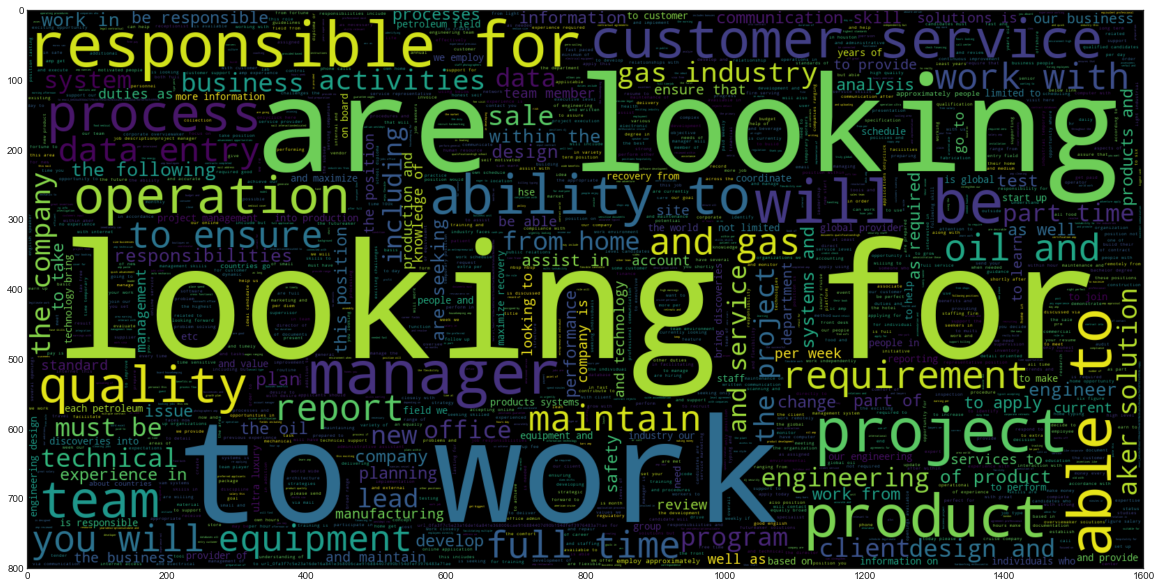

In [204]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.fraudulent == 1].description))
plt.imshow(wc , interpolation = 'bilinear')

Create bag of words for each text field for LDA
- Drop stop words
- Stem all words 


In [ ]:
### need to do more cleaning. get rid of long alphanumeric strings -- see what is returned by get_feature_names

In [24]:
def stemming_tokenizer(str_input):
    
    # initialize Porter Stemmer
    stemmer = PorterStemmer()

    # tokenize input words and stem
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [stemmer.stem(word) for word in words]
    
    return words

In [29]:
nlp_columns = ['company_profile', 'description', 'requirements', 'benefits']

vectorizer = CountVectorizer(tokenizer=stemming_tokenizer, stop_words = 'english')

for c in nlp_columns:
    df[c + '_vector'] = vectorizer.fit_transform(df[c])
    
#vectorizer.get_feature_names()

In [99]:
len(df)

17880

In [100]:
df.title.nunique() # how do we consolidate titles?? or maybe just use industry and function instead? 

10533

In [83]:
list(df.title.unique())

['marketing intern',
 'customer service - cloud video production',
 'commissioning machinery assistant (cma)',
 'account executive - washington dc',
 'bill review manager',
 'accounting clerk',
 'head of content (m/f)',
 'lead guest service specialist',
 'hp bsm sme',
 'customer service associate - part time',
 'asp.net developer job opportunity at united states,new jersey',
 'talent sourcer (6 months fixed-term contract)',
 'applications developer, digital',
 'installers',
 'account executive - sydney',
 'vp of sales - vault dragon',
 'hands-on qa leader',
 'southend-on-sea traineeships under nas 16-18 year olds only',
 'visual designer',
 'process controls engineer - dcs plc ms office - pa',
 'marketing assistant',
 'front end developer',
 'engagement manager',
 'vice president, sales and sponsorship (businessfriend.com)',
 'customer service',
 'h1b sponsor for l1/l2/opt',
 'marketing exec',
 'haad/dha licensed doctors opening in uae',
 'talent management process manager',
 'customer